In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [2]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

# Initial Analysis

Pandas user guide: https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html

Pandas 10 min tutorial: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

In [3]:
# dataset head
df.head(10)

age  income  frq  rcn   mnt  clothes  kitchen  small_appliances  toys  \
0  1946   90782   33   66  1402       37        5                44    10   
1  1936  113023   32    6  1537       55        1                38     4   
2  1990   28344   11   69    44       32       19                24     1   
3  1955   93571   26   10   888       60       10                19     6   
4  1955   91852   31   26  1138       59        5                28     4   
5  1982   22386   14   65    56       47        2                48     2   
6  1969   69485   18   73   345       71        7                13     1   
7  1960   68602    5   44    41       84        1                12     2   
8  1940  109499   30   75  1401       38        9                35     9   
9  1994   23846    8  153    19       18       55                17    10   

   house_keeping dependents  per_net_purchase gender   education    status  \
0              3          0                19      M  Graduation  Together   
1              2          0                 9      F         PhD  Divorced   
2             24          1                59      M  Graduation   Married   
3              5          1                35      F      Master             
4              4          1                34      F  Graduation  Together   
5              1          1                67      M         PhD    Single   
6              8          1                46      M  Graduation  Together   
7              0          1                37      M  Graduation  Together   
8              9          0                17      M  Graduation  Divorced   
9              1          1                39      F   1st Cycle  Together   

       description  
0  Take my money!!  
1  Take my money!!  
2       Kind of OK  
3         OK nice!  
4  Take my money!!  
5         OK nice!  
6         OK nice!  
7         Horrible  
8         OK nice!  
9           Meh...

In [4]:
# dataset data types
df.dtypes

age                  int64
income              object
frq                  int64
rcn                  int64
mnt                  int64
clothes              int64
kitchen              int64
small_appliances     int64
toys                 int64
house_keeping        int64
dependents          object
per_net_purchase     int64
gender              object
education           object
status              object
description         object
dtype: object

In [5]:
# count of missing values
df.isna().sum()

age                 0
income              0
frq                 0
rcn                 0
mnt                 0
clothes             0
kitchen             0
small_appliances    0
toys                0
house_keeping       0
dependents          0
per_net_purchase    0
gender              0
education           0
status              0
description         0
dtype: int64

In [6]:
# duplicated observations
df.duplicated().sum()

0

In [7]:
# descriptive statistics
df.describe(include="all").T  # try with all and without all

count unique         top  freq     mean      std   min   25%  \
age               8998    NaN         NaN   NaN  1966.06  17.2966  1936  1951   
income            8998   8525                46      NaN      NaN   NaN   NaN   
frq               8998    NaN         NaN   NaN  19.8481  10.9034     3    10   
rcn               8998    NaN         NaN   NaN  62.4698  69.7618     0    26   
mnt               8998    NaN         NaN   NaN  622.163  646.768     6    63   
clothes           8998    NaN         NaN   NaN  50.4467  23.4222     1    33   
kitchen           8998    NaN         NaN   NaN  7.03968  7.84814     0     2   
small_appliances  8998    NaN         NaN   NaN  28.5241  12.5864     1    19   
toys              8998    NaN         NaN   NaN   7.0369  7.92442     0     2   
house_keeping     8998    NaN         NaN   NaN  6.92998  7.88266     0     2   
dependents        8998      3           1  6164      NaN      NaN   NaN   NaN   
per_net_purchase  8998    NaN         NaN   NaN   42.429  18.4957     4    28   
gender            8998      2           M  5784      NaN      NaN   NaN   NaN   
education         8998      7  Graduation  4429      NaN      NaN   NaN   NaN   
status            8998      7     Married  3273      NaN      NaN   NaN   NaN   
description       8998      5    OK nice!  3434      NaN      NaN   NaN   NaN   

                   50%   75%   max  
age               1966  1981  1996  
income             NaN   NaN   NaN  
frq                 17    28    59  
rcn                 53    79   549  
mnt                383  1076  3052  
clothes             51    69    99  
kitchen              4    10    75  
small_appliances    28    37    74  
toys                 4    10    62  
house_keeping        4     9    77  
dependents         NaN   NaN   NaN  
per_net_purchase    45    57    88  
gender             NaN   NaN   NaN  
education          NaN   NaN   NaN  
status             NaN   NaN   NaN  
description        NaN   NaN   NaN

## Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

In [8]:
# Use this cell to further explore the dataset
# CODE HERE

In [9]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

# count of missing values
df.isna().sum()

age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [10]:
# check dataset data types again
df.dtypes

age                   int64
income              float64
frq                   int64
rcn                   int64
mnt                   int64
clothes               int64
kitchen               int64
small_appliances      int64
toys                  int64
house_keeping         int64
dependents          float64
per_net_purchase      int64
gender               object
education            object
status               object
description          object
dtype: object

In [11]:
df.dependents = df.dependents.astype(bool)

In [12]:
# check descriptive statistics again
df.describe(include="all").T

count unique         top  freq     mean      std    min  \
age               8998    NaN         NaN   NaN  1966.06  17.2966   1936   
income            8952    NaN         NaN   NaN  69963.6  27591.6  10000   
frq               8998    NaN         NaN   NaN  19.8481  10.9034      3   
rcn               8998    NaN         NaN   NaN  62.4698  69.7618      0   
mnt               8998    NaN         NaN   NaN  622.163  646.768      6   
clothes           8998    NaN         NaN   NaN  50.4467  23.4222      1   
kitchen           8998    NaN         NaN   NaN  7.03968  7.84814      0   
small_appliances  8998    NaN         NaN   NaN  28.5241  12.5864      1   
toys              8998    NaN         NaN   NaN   7.0369  7.92442      0   
house_keeping     8998    NaN         NaN   NaN  6.92998  7.88266      0   
dependents        8998      2        True  6446      NaN      NaN    NaN   
per_net_purchase  8998    NaN         NaN   NaN   42.429  18.4957      4   
gender            8998      2           M  5784      NaN      NaN    NaN   
education         8951      6  Graduation  4429      NaN      NaN    NaN   
status            8821      6     Married  3273      NaN      NaN    NaN   
description       8998      5    OK nice!  3434      NaN      NaN    NaN   

                    25%      50%    75%     max  
age                1951     1966   1981    1996  
income            47741  70030.5  92218  140628  
frq                  10       17     28      59  
rcn                  26       53     79     549  
mnt                  63      383   1076    3052  
clothes              33       51     69      99  
kitchen               2        4     10      75  
small_appliances     19       28     37      74  
toys                  2        4     10      62  
house_keeping         2        4      9      77  
dependents          NaN      NaN    NaN     NaN  
per_net_purchase     28       45     57      88  
gender              NaN      NaN    NaN     NaN  
education           NaN      NaN    NaN     NaN  
status              NaN      NaN    NaN     NaN  
description         NaN      NaN    NaN     NaN

# Visual Exploration

Matplotlib tutorials: https://matplotlib.org/3.3.1/tutorials/index.html

Matplotlib gallery: https://matplotlib.org/3.3.1/tutorials/introductory/sample_plots.html#sphx-glr-tutorials-introductory-sample-plots-py

Seaborn tutorials: https://seaborn.pydata.org/tutorial.html


Seaborn gallery: https://seaborn.pydata.org/examples/index.html

In [13]:
#Define metric and non-metric features. Why?
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

## Pyplot-style vs Object-Oriented-style
- Explicitly create figures and axes, and call methods on them (the "object-oriented (OO) style").
- Rely on pyplot to automatically create and manage the figures and axes, and use pyplot functions for plotting.

## Pairwise Relationship of Numerical Variables

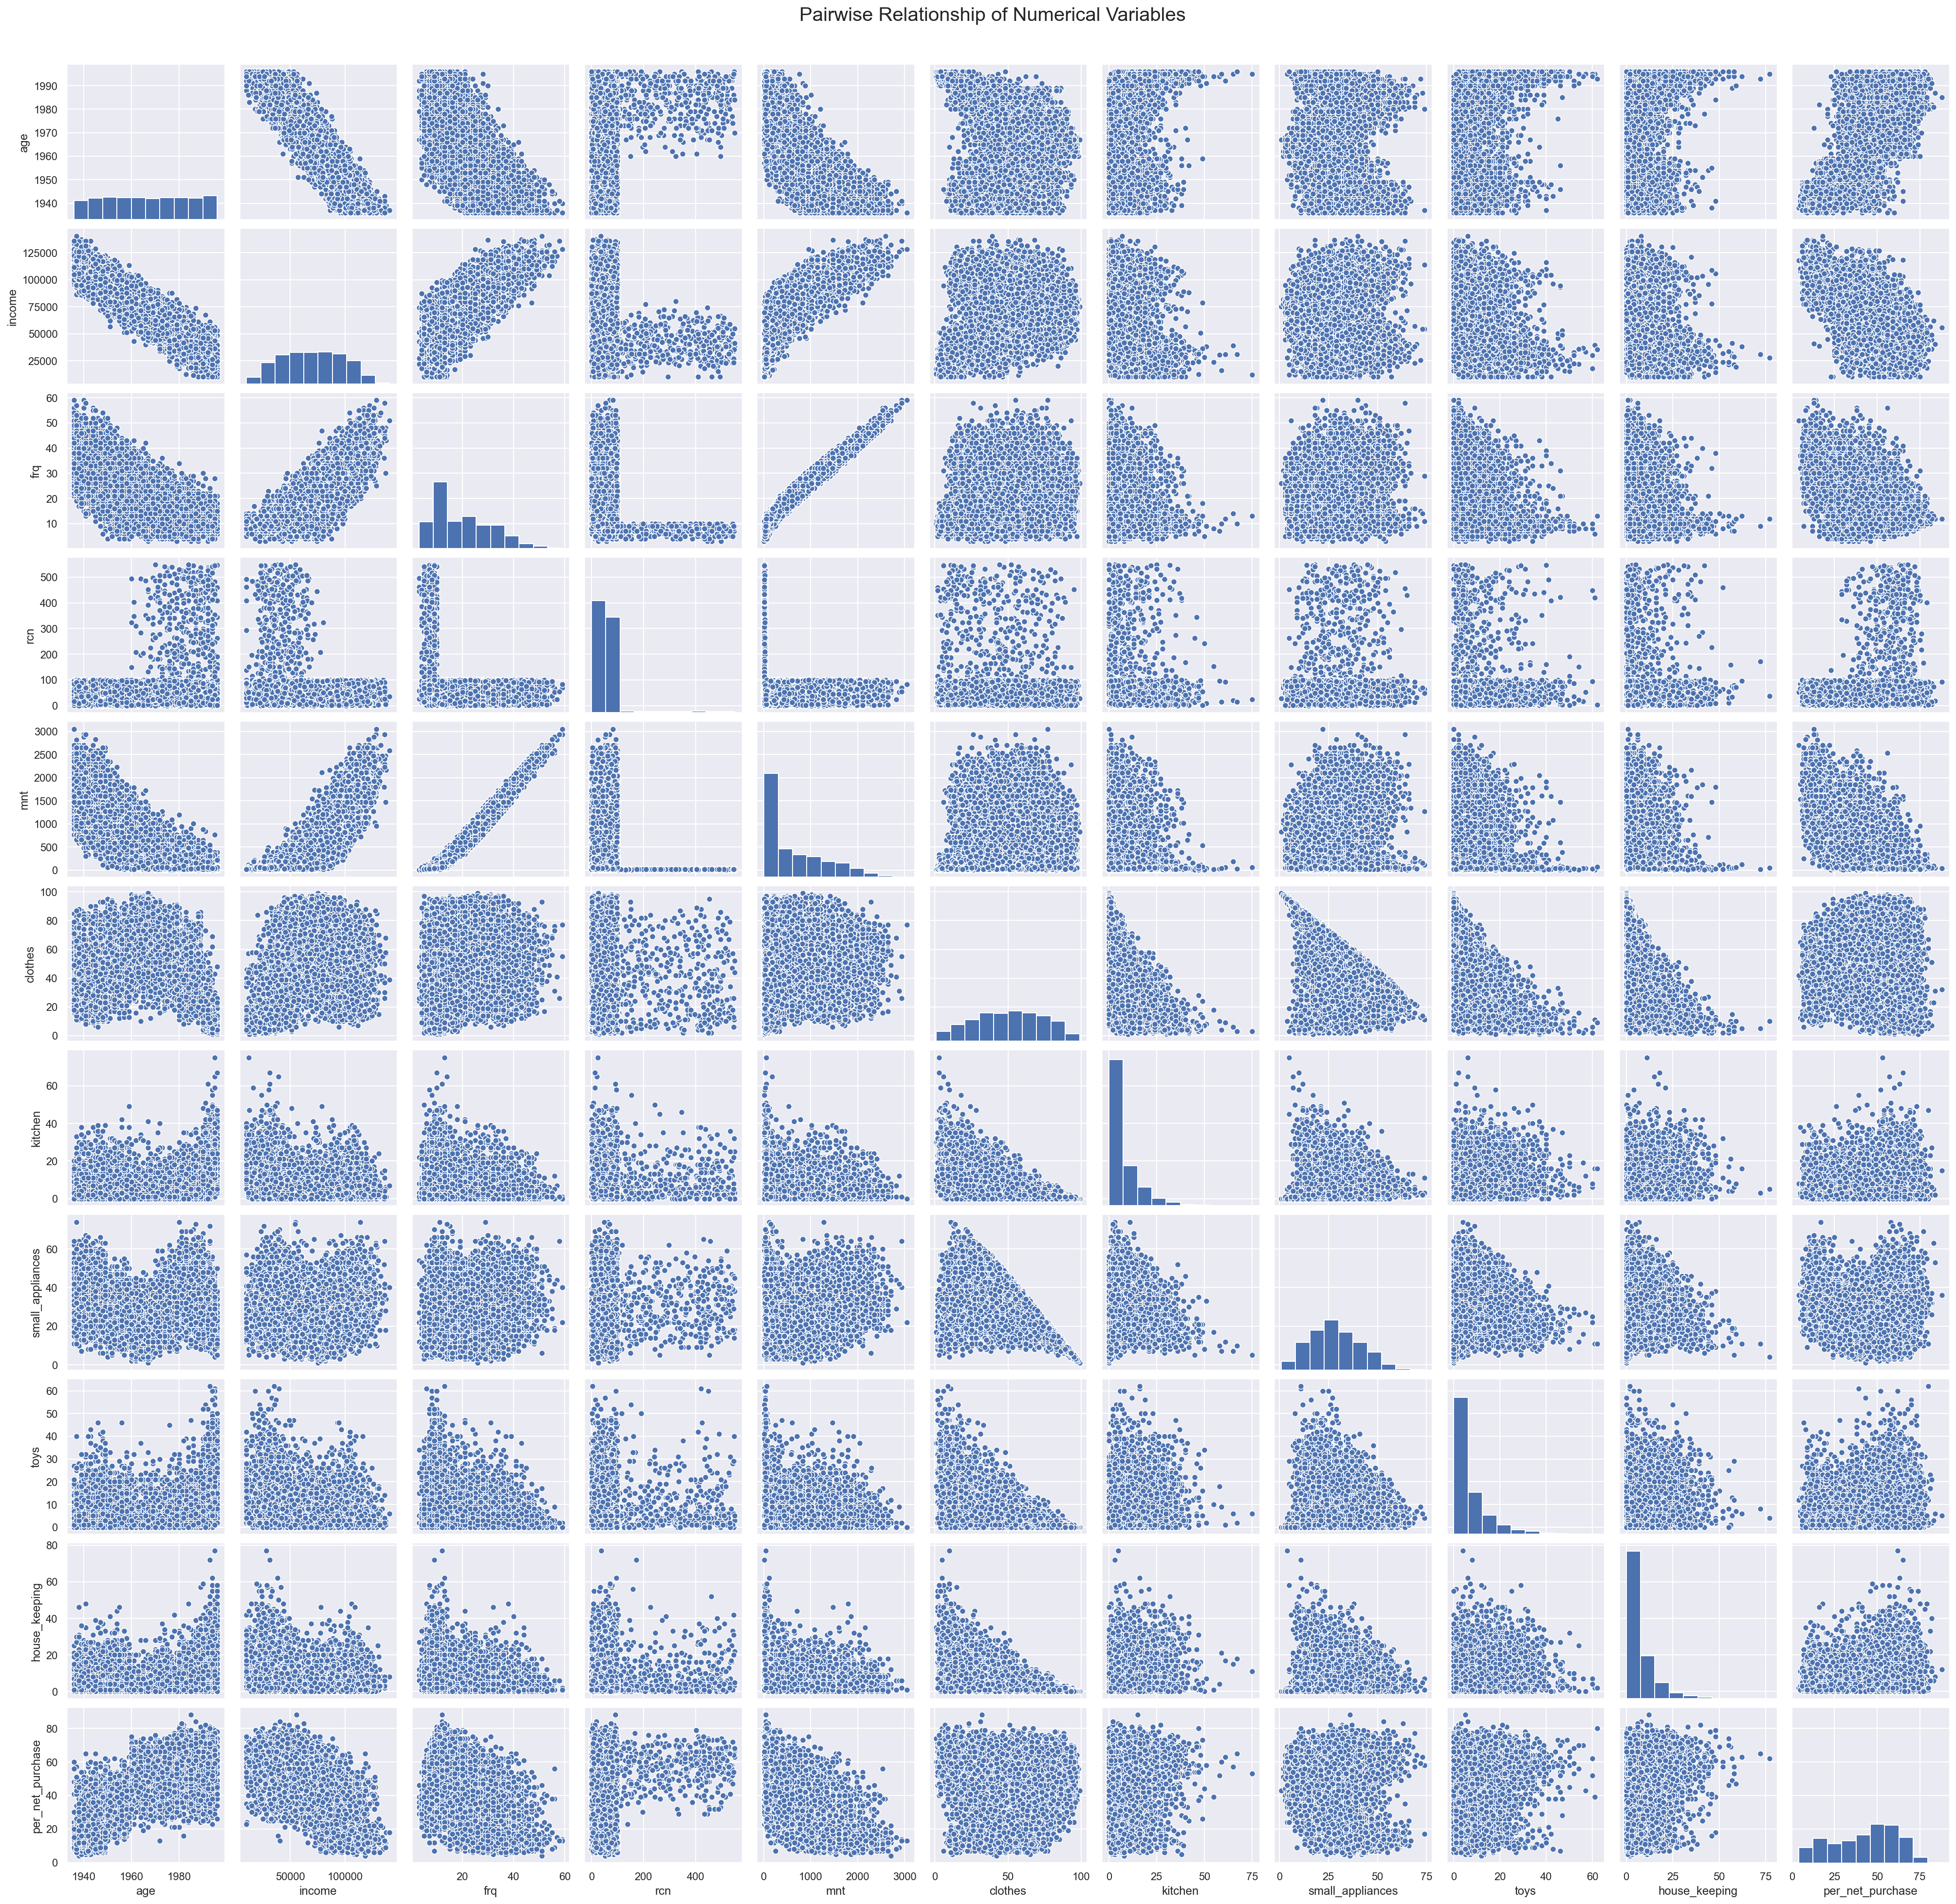

In [14]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

### Insights:
- possible bivariate relationships
- potential bivariate outliers
- univariate distributions (diagonal)

## Numeric Variables' Box Plots

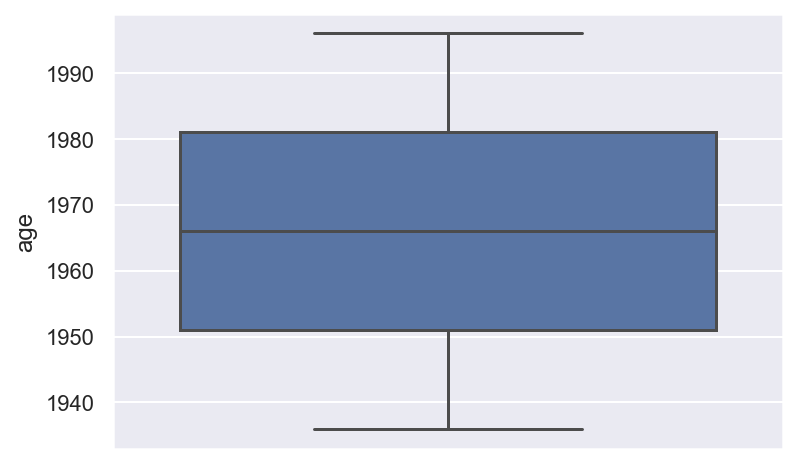

In [15]:
# Single Metric Variable Box Plot
sns.boxplot(y=df["age"])

plt.show()

What information can we extract from the plot above?

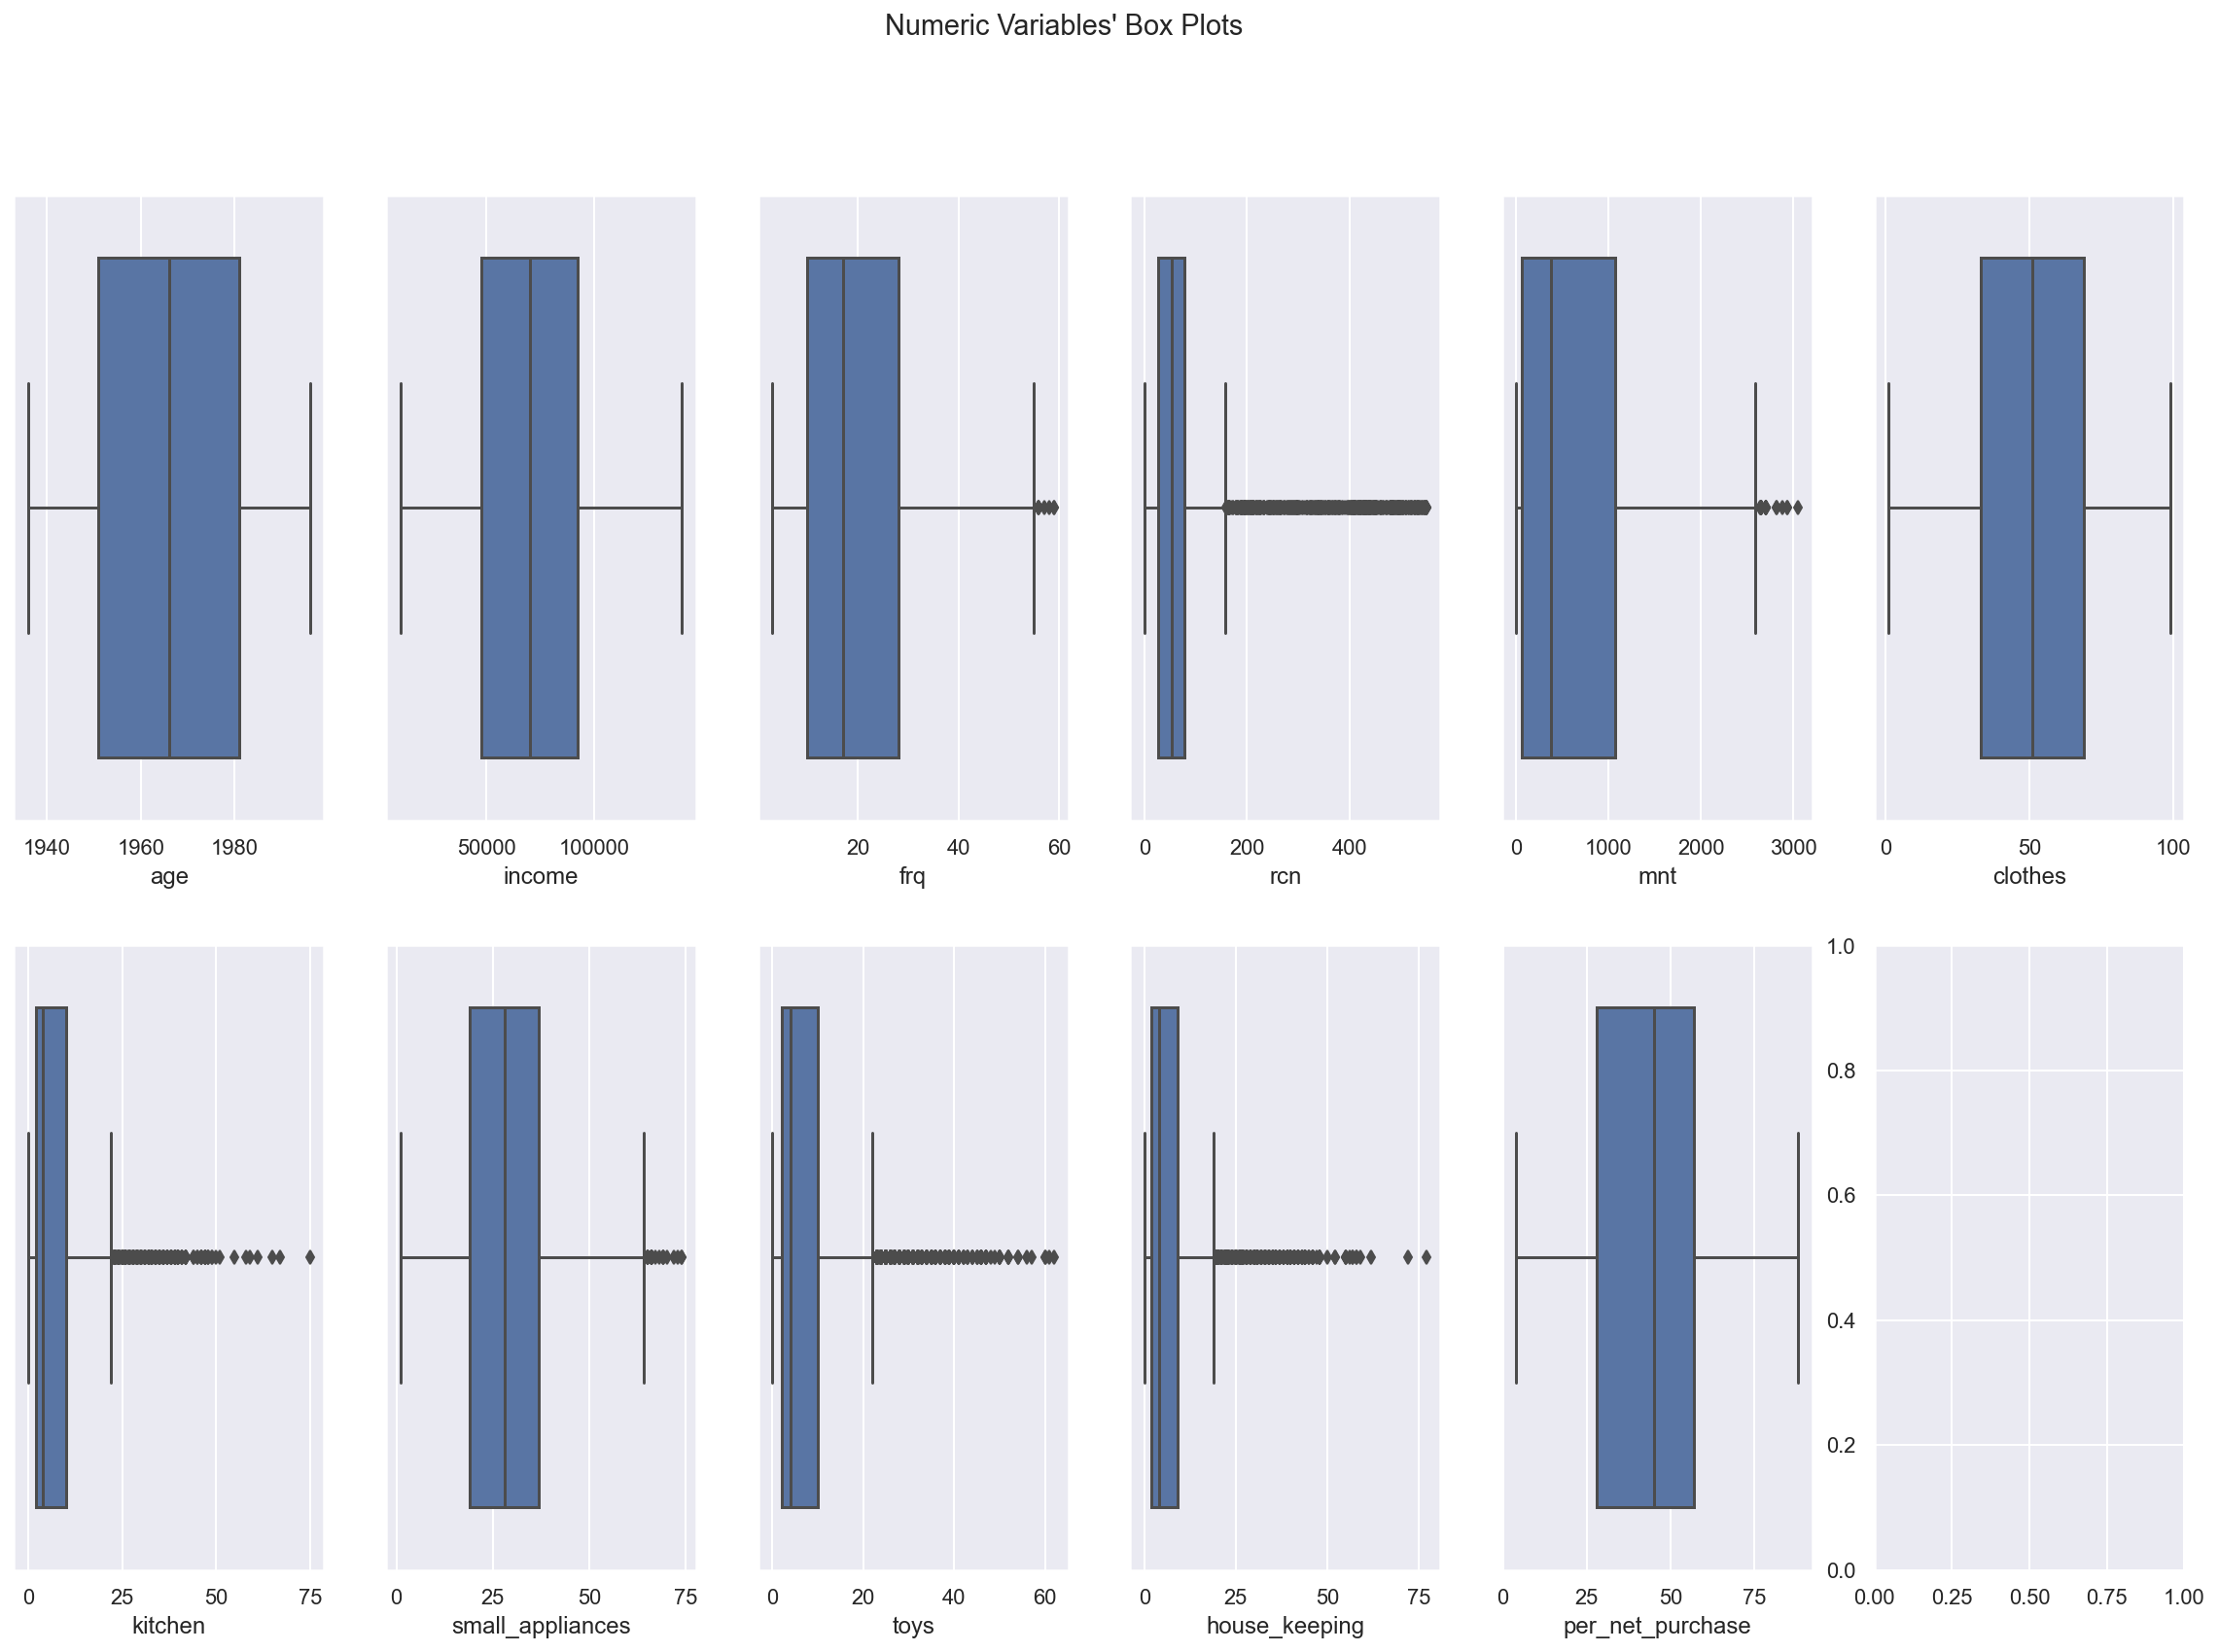

In [16]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 13))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

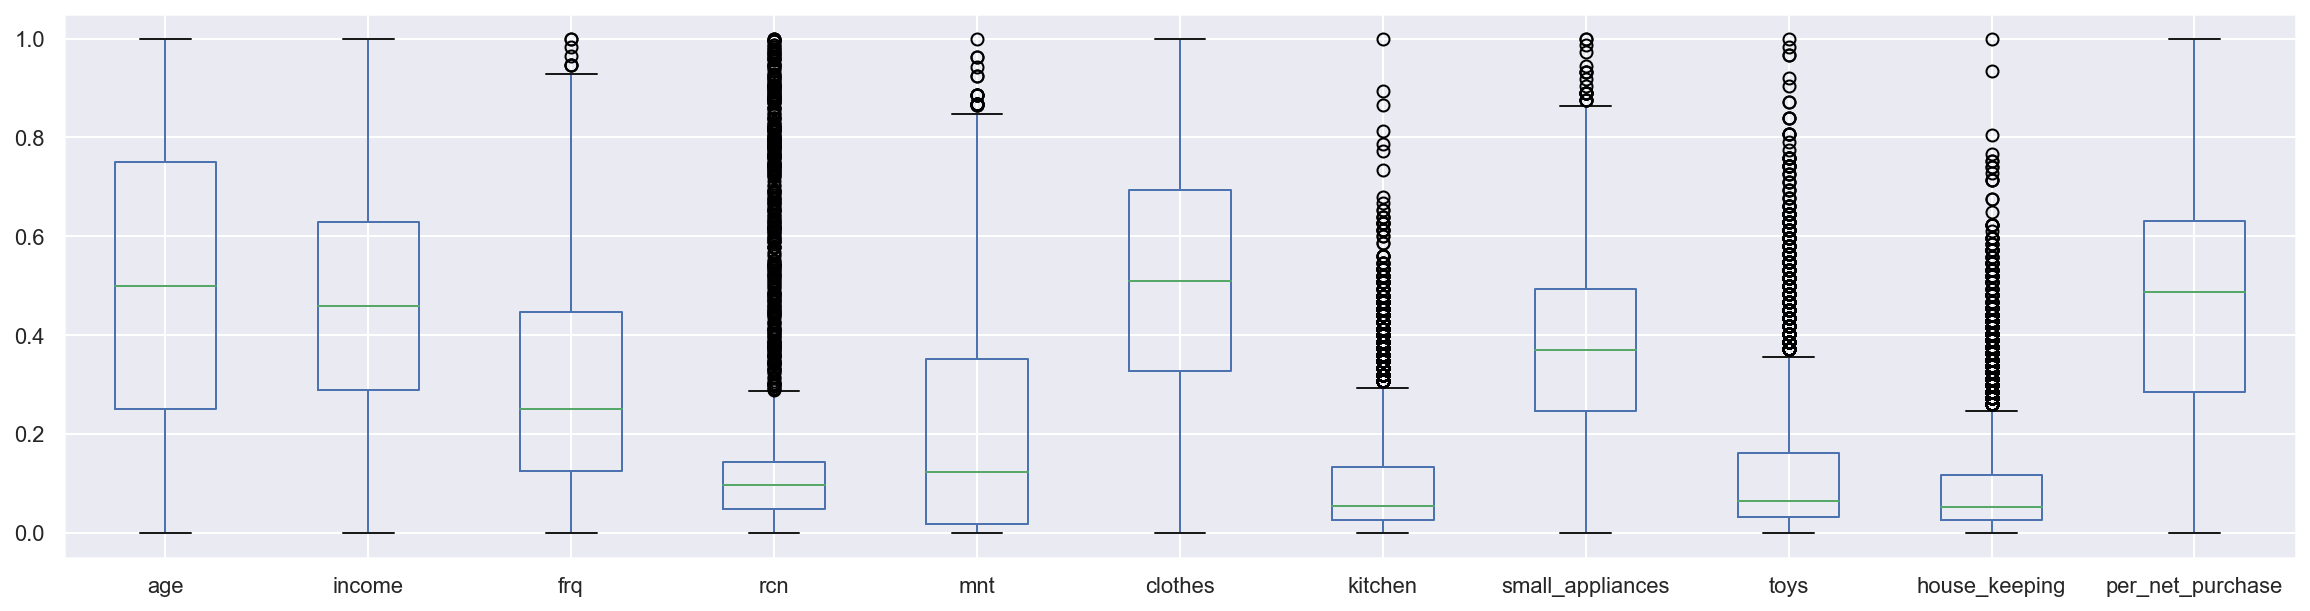

In [17]:
# Now let's do these plots into a single axis, using only Pandas
df_box_plts = df[metric_features].copy()

df_box_plts.iloc[:,:] = MinMaxScaler().fit_transform(df_box_plts)

df_box_plts.plot.box(figsize=(20,5))
plt.show()

### Insights:
- univariate distributions
- potential univariate outliers

## Categorical/Low Cardinality Variables' Absolute Frequencies

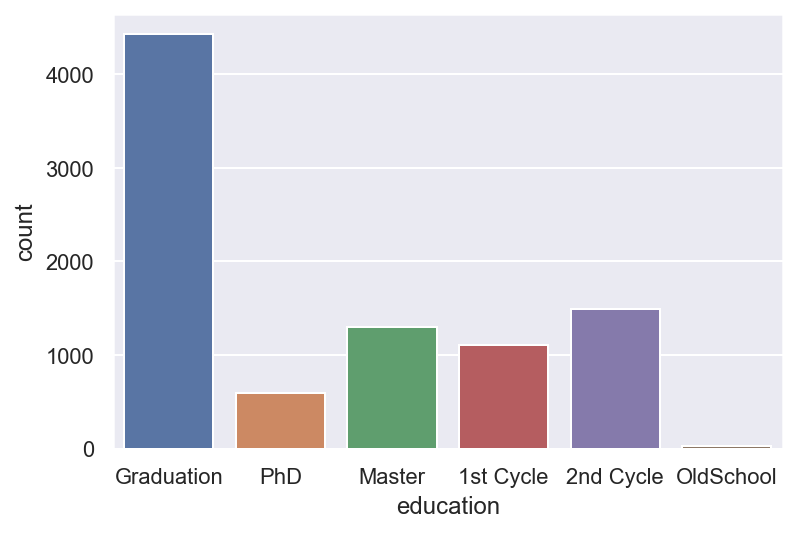

In [18]:
# Single Non-Metric variable bar plot
sns.countplot(x=df["education"])

plt.show()

What information can we extract from the plot above?

**Using the same logic from the multiple box plot figure above, build a multiple bar plot figure for each non-metric variable:**

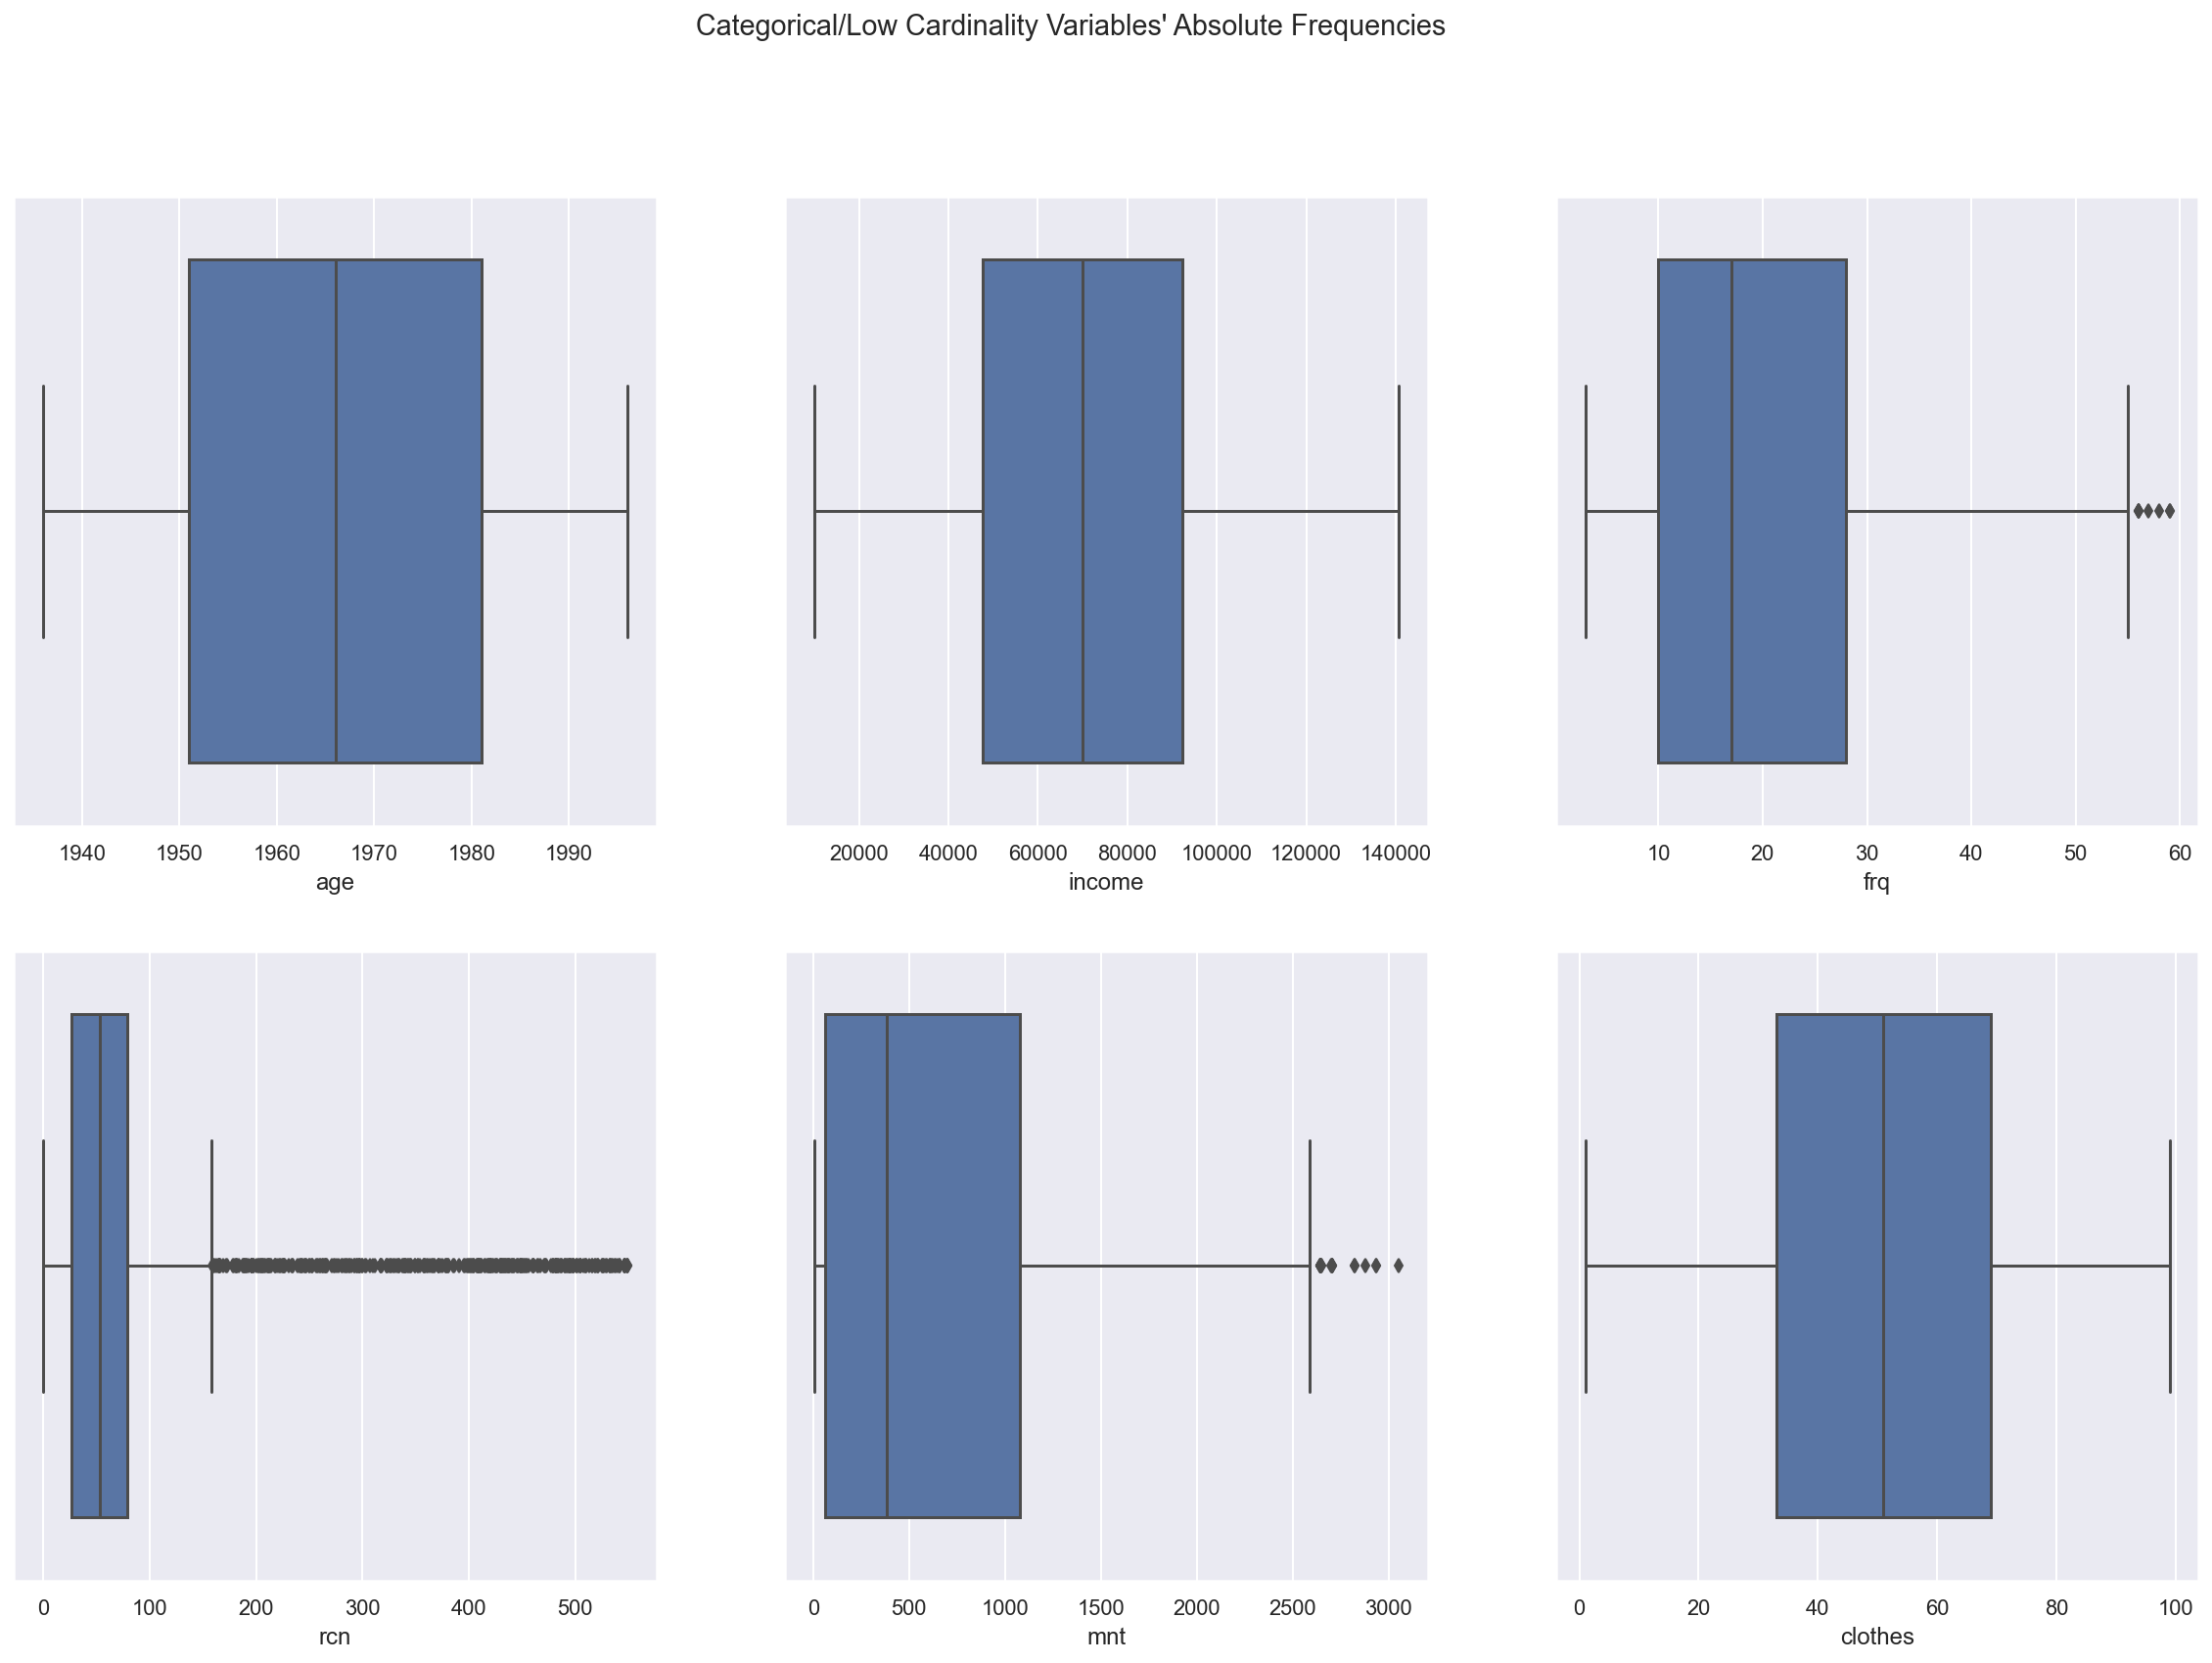

In [22]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 13))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(df[feat], ax=ax)

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

### Insights:
- low frequency values
- high cardinality

## Metric Variables' Correlation Matrix

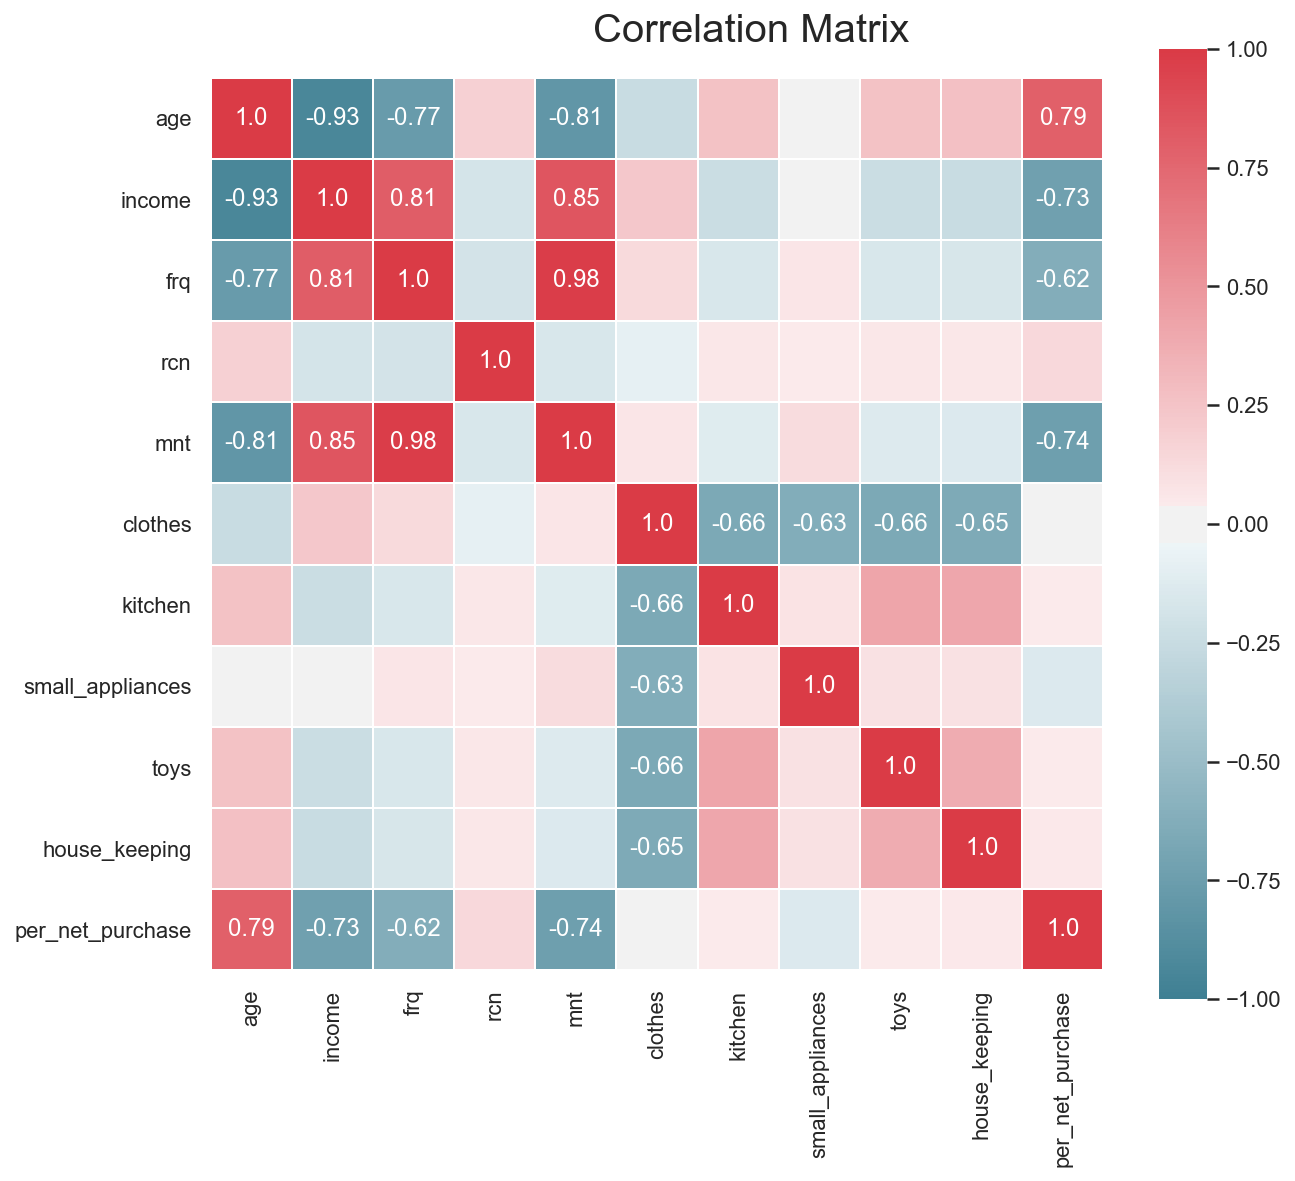

In [26]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

# Coherence Check

# Outliers

# Missing Values

# Feature Engineering